# Introduction


In this competition, the task is to predict whether the 418 people mentioned in the test.csv survived, given the data in train.csv


The competitions page: [Titanic](https://kaggle.com/competitions/titanic)

 

# Exploring the data

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [84]:
data_train = pd.read_csv("/kaggle/input/titanic/train.csv",index_col='PassengerId')
data_test  = pd.read_csv("/kaggle/input/titanic/test.csv")


Lets have a look at the data :

In [85]:
data_shape = data_train.shape
print("Data consists of ", data_shape[0], " rows and ",  data_shape[1]-2, " features")
data_train.head()


Data consists of  891  rows and  9  features


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


First lets have a look a missing values

In [86]:
data_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

We cannot remove the missing data as there might the missing data might not be random. Now lets see if there is any connection between missing Cabin numbers and the Survived values. We first encode values as: 1, if the Cabin number is missing and 0, if the Cabin number is not missing and plot Crosstable: 

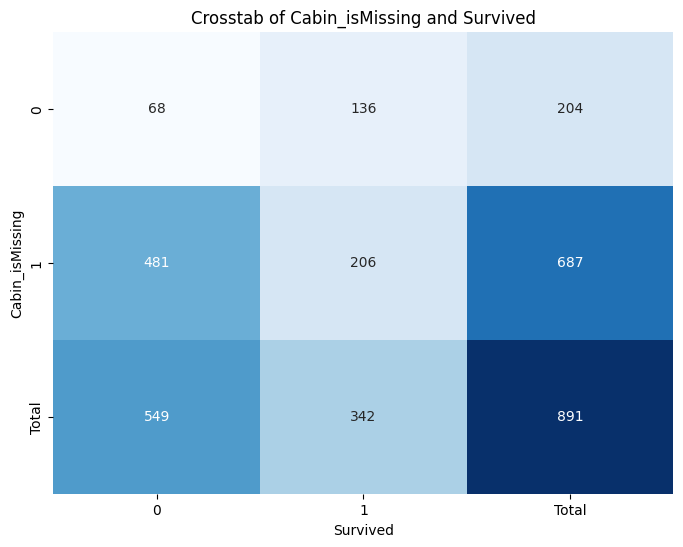

In [87]:
# 1, if isnull and 0 if is not a null
data_train["Cabin_isMissing"] = data_train["Cabin"].isnull().astype(int)

crosstab = pd.crosstab(data_train['Cabin_isMissing'], data_train['Survived'], margins=True, margins_name="Total")
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Crosstab of Cabin_isMissing and Survived')
plt.ylabel('Cabin_isMissing')
plt.xlabel('Survived')
plt.show()

There is a reason to assume that those with a missing cabin number have a higher probability of not surviving. Let's compare if missing Cabin numbeer with the Fare column. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

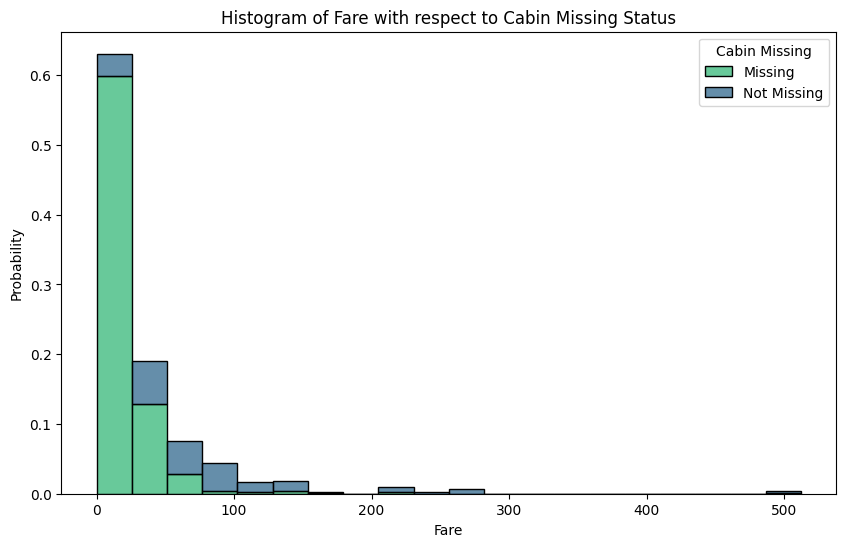

In [88]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_train, x='Fare', hue='Cabin_isMissing', multiple='stack', bins =20 ,stat='probability', palette='viridis')
plt.title('Histogram of Fare with respect to Cabin Missing Status')
plt.xlabel('Fare')
plt.ylabel('Probability')
plt.legend(title='Cabin Missing', labels=['Missing', 'Not Missing'])
plt.show()

We can see that having a missing Cabin number means lower Fare value. Most people with missing Cabin number have a small Fare value. Thus the missing Cabin rows cannot be removed. Lets see what can be said about missing age values. 

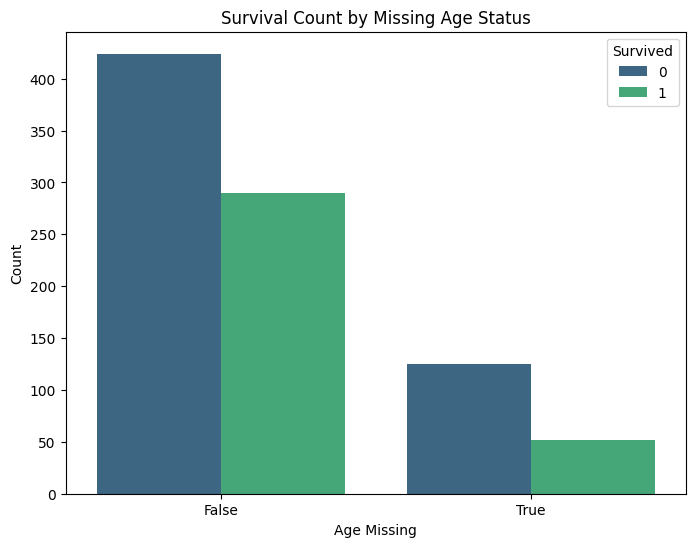

In [89]:
data_train['Age_missing'] = data_train['Age'].isnull()
plt.figure(figsize=(8, 6))
sns.countplot(x='Age_missing', hue='Survived', data=data_train, palette='viridis')
plt.title('Survival Count by Missing Age Status')
plt.xlabel('Age Missing')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show()

There might not be a clear connection between haveing a missing Age value and Survived status. 

In [90]:
Nr_survived = data_train['Survived'].sum()
# Probability of Survived = 1 
Nr_survived / data_shape[0]

0.3838383838383838

There more people that did not survive what might explain why there are more that did not survive in each category. Lets look at age between different categories. First we encode Sex feature to 1, if male and 0, if female. 

In [91]:
data_train['Sex_encoded'] = data_train['Sex'].map({'male': 1, 'female': 0})
Nr_male = data_train['Sex_encoded'].sum()
# Probability of Survived = 1 
Nr_male / data_shape[0]

0.6475869809203143

There are more Male in the data, but not that much more. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

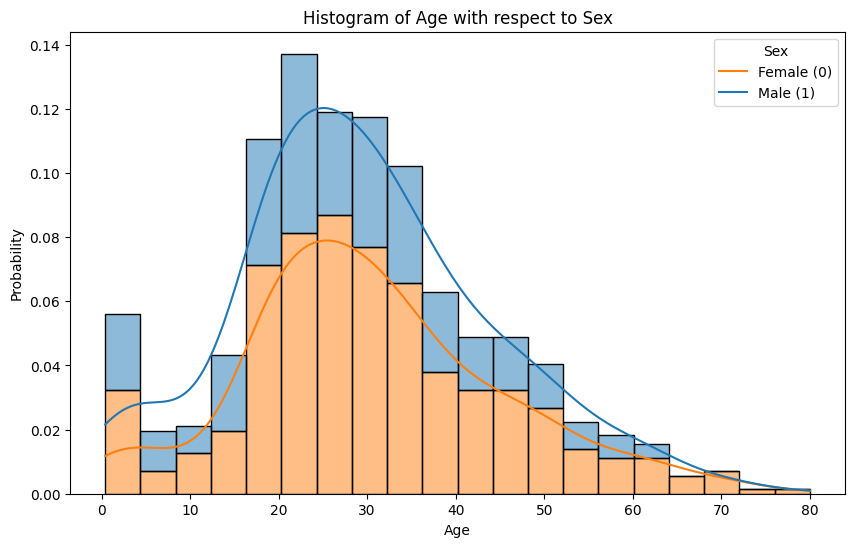

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_train, x='Age', hue='Sex_encoded',kde=True, multiple='stack', bins=20, stat='probability')
plt.title('Histogram of Age with respect to Sex')
plt.xlabel('Age')
plt.ylabel('Probability')
plt.legend(title='Sex', labels=['Female (0)', 'Male (1)'])
plt.show()

The probability distributions of age between genders have similar form but are differen. Thus, when dealing with missing age, it might be better to encode them as median of age w.r.t. Sex. Mayber we can say something of the missing age if we look at sibsp or parch column: 


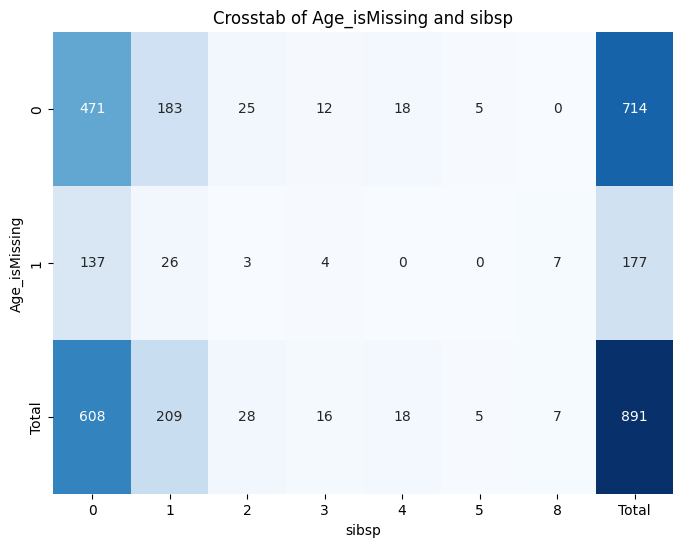

In [93]:
data_train["Age_isMissing"] = data_train["Age"].isnull().astype(int)

crosstab = pd.crosstab(data_train['Age_isMissing'], data_train['SibSp'], margins=True, margins_name="Total")
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Crosstab of Age_isMissing and sibsp')
plt.ylabel('Age_isMissing')
plt.xlabel('sibsp')
plt.show()

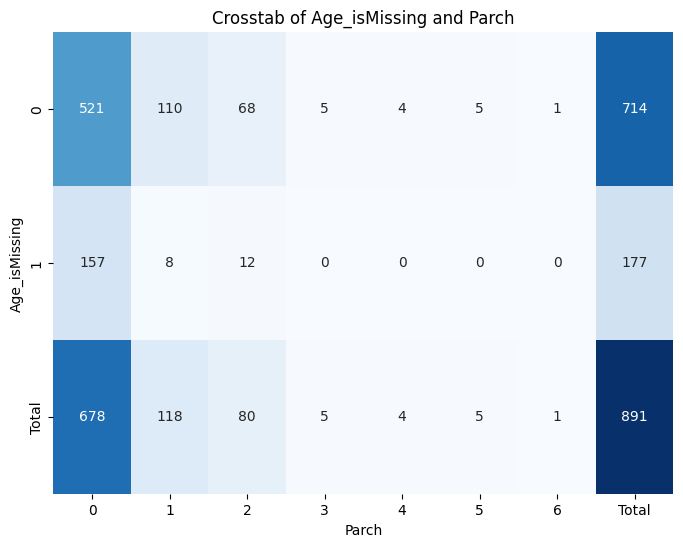

In [94]:
crosstab = pd.crosstab(data_train['Age_isMissing'], data_train['Parch'], margins=True, margins_name="Total")
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Crosstab of Age_isMissing and Parch')
plt.ylabel('Age_isMissing')
plt.xlabel('Parch')
plt.show()

It seems that most of the people with missing age have no relatives with them. It might be reasonable to encode missing age as median from the group that have 0 relatives on board. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


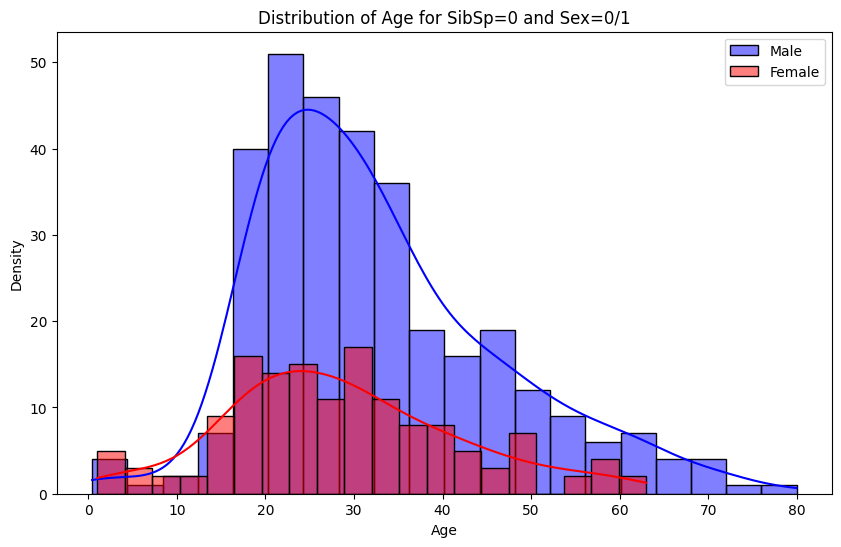

In [95]:
# Filter rows where 'SibSp' is 0 and 'Sex' is either 0 or 1
filtered_data_male_SibSp = data_train[(data_train['SibSp'] == 0) & (data_train['Sex_encoded'] == 1)]
filtered_data_female_SibSp = data_train[(data_train['SibSp'] == 0) & (data_train['Sex_encoded'] == 0)]

# Plot the distributions of 'Age' for Male and Female separately
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data_male_SibSp, x='Age', bins=20, kde=True, color='blue', label='Male')
sns.histplot(data=filtered_data_female_SibSp, x='Age', bins=20, kde=True, color='red', label='Female')

plt.title('Distribution of Age for SibSp=0 and Sex=0/1')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


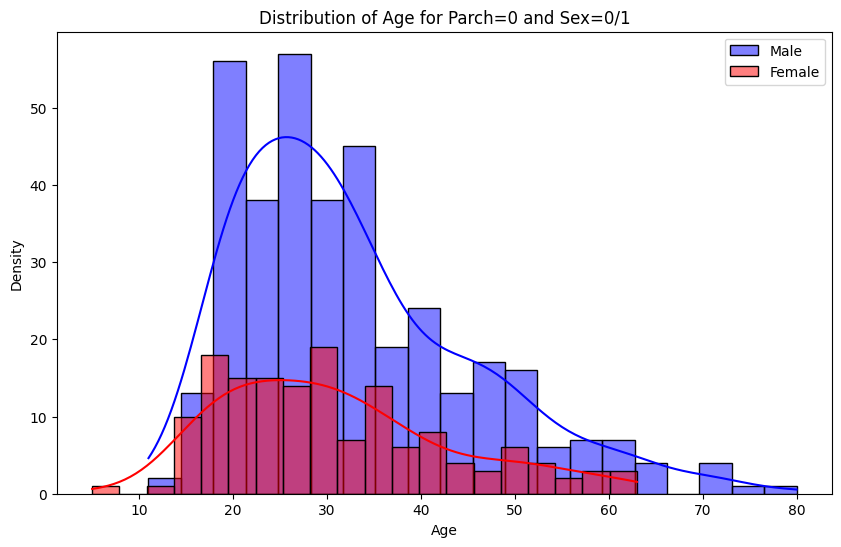

In [96]:
# Filter rows where 'SibSp' is 0 and 'Sex' is either 0 or 1
filtered_data_male_Parch = data_train[(data_train['Parch'] == 0) & (data_train['Sex_encoded'] == 1)]
filtered_data_female_Parch = data_train[(data_train['Parch'] == 0) & (data_train['Sex_encoded'] == 0)]

# Plot the distributions of 'Age' for Male and Female separately
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_data_male_Parch, x='Age', bins=20, kde=True, color='blue', label='Male')
sns.histplot(data=filtered_data_female_Parch, x='Age', bins=20, kde=True, color='red', label='Female')

plt.title('Distribution of Age for Parch=0 and Sex=0/1')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

Thus the encoding will be done by taking median of Parch = 0 and SibSp =0  and taking mean of these values w.r.t. Sex. 

In [97]:
encode_male =  (filtered_data_male_Parch['Age'].median()+filtered_data_male_SibSp['Age'].median() )/2
encode_female =  (filtered_data_female_Parch['Age'].median()+filtered_data_female_SibSp['Age'].median() )/2
print("Male age will be encoded as: ", encode_male, " and female age will be encoded as: ", encode_female)

Male age will be encoded as:  30.0  and female age will be encoded as:  28.0


In [98]:
# Replace missing age values for males with encode_male
data_train.loc[(data_train['Sex_encoded'] == 1) & (data_train['Age'].isnull()), 'Age'] = encode_male

# Replace missing age values for females with encode_female
data_train.loc[(data_train['Sex_encoded'] == 0) & (data_train['Age'].isnull()), 'Age'] = encode_female


Last thing is to encode Embarked column. For now, they are enoceded with another variable. There are only 2 missingg values. 

In [99]:
data_train['Embarked'] = data_train['Embarked'].fillna('Missing')
label_encoder = LabelEncoder()
data_train['Embarked_encoded'] = label_encoder.fit_transform(data_train['Embarked'])

# Making a model

In [100]:
train_features = ["Pclass","Sex_encoded","Age","SibSp","Parch","Fare","Embarked_encoded"]


X = data_train[["Pclass","Sex_encoded","Age","SibSp","Parch","Fare","Embarked_encoded"]]
y = data_train["Survived"]

For training the model, we split the data in 2 parts, one for training and one for validation.  

In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


We must remember that the number of people that surived are much smaller and thus the final prediction should be weighted. 

In [102]:
weight_for_0 =  1 /(Nr_survived / data_shape[0])
weight_for_1 = 1 / (1- Nr_survived / data_shape[0])
class_weights = {0: weight_for_0, 1: weight_for_1}

For parameter tuning, a param_grid is defined below. When training, the model will be trained trying each combination of parameters and in the end, will select the best combination.

In [103]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

In this work, Random Forest Classifier is used. 

In [104]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)


In [105]:


# Fit the classifier to the training data
grid_search.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = grid_search.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8385650224215246




In this competition: Accuracy = $\frac{\text{Correct classifications}}{\text{ Total classifications}}$

Now prepare the test data

In [106]:
data_test['Embarked'] = data_test['Embarked'].fillna('Missing')
data_test['Embarked_encoded'] = label_encoder.fit_transform(data_test['Embarked'])
data_test['Sex_encoded'] = data_test['Sex'].map({'male': 1, 'female': 0})

filtered_data_male_Parch = data_test[(data_test['Parch'] == 0) & (data_test['Sex_encoded'] == 1)]
filtered_data_female_Parch = data_test[(data_test['Parch'] == 0) & (data_test['Sex_encoded'] == 0)]
filtered_data_male_SibSp = data_test[(data_test['SibSp'] == 0) & (data_test['Sex_encoded'] == 1)]
filtered_data_female_SibSp = data_test[(data_test['SibSp'] == 0) & (data_test['Sex_encoded'] == 0)]

encode_male =  (filtered_data_male_Parch['Age'].median()+filtered_data_male_SibSp['Age'].median() )/2
encode_female =  (filtered_data_female_Parch['Age'].median()+filtered_data_female_SibSp['Age'].median() )/2
data_test.loc[(data_test['Sex_encoded'] == 1) & (data_test['Age'].isnull()), 'Age'] = encode_male
data_test.loc[(data_test['Sex_encoded'] == 0) & (data_test['Age'].isnull()), 'Age'] = encode_female
data_test["Fare"] = data_test['Fare'].fillna(data_test['Fare'].median() )



Predict the Survival of the test data and make submission file. 

In [107]:
test_X = data_test[train_features]
Predictions = grid_search.predict(test_X)

In [108]:
output = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': Predictions})
output.to_csv('/kaggle/working/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
